Multiple states

In [1]:
using NLOptControl
using Polynomials
using Plots
using Parameters
pyplot()

Plots.PyPlotBackend()


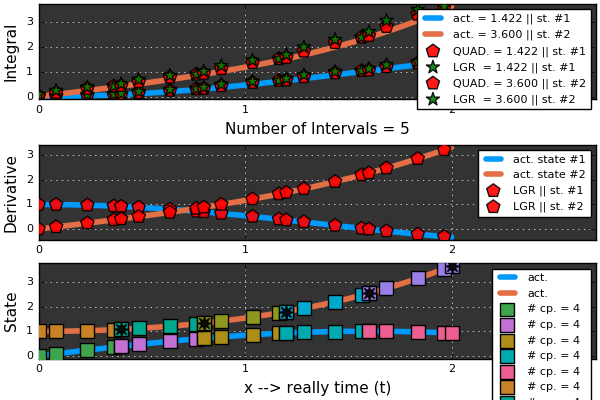

/home/febbo/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [5]:
############
# TEST DATA
############
t0 = Float64(0); tf = Float64(2);
t = Array(linspace(t0,tf,100));

# sin and cos taylor series approximation at x = 0
s0 =  0; s1 = 1; s2 = 0;       s3 = -1/(3*2*1); s4 = 0;           s5 = 1/(5*4*3*2*1); 
c0 = 1;  c1 = 0; c2 = 1/(2*1); c3 = 0;          c4 = 1/(4*3*2*1); c5 = 0; 
γ1 = Poly([s0,s1,s2,s3,s4,s5]);  # state 1
γ2 = Poly([c0,c1,c2,c3,c4,c5]);  # state 2
γ = [γ1; γ2]; numStates=length(γ);
y = [polyval(γ[st],t) for st in 1:numStates];

# evaluate the integrals
∫γ = [polyint(γ[st]) for st in 1:numStates];
Y  = [polyval(∫γ[st],t[end]) - polyval(∫γ[st],t[1]) for st in 1:numStates];
C  = [Y[st] - polyval(∫γ[st],t[end]) for st in 1:numStates]; # constant of integration
∫y = [polyval(∫γ[st],t) + C[st] for st in 1:numStates];

# evaluate the derivatives
dγ = [polyder(γ[st]) for st in 1:numStates];
dy = [polyval(dγ[st],t) for st in 1:numStates];
############
# TEST DATA
############
dx1(t) = 1.0 - 0.5⋅t^2 + 0.0416667⋅t^4;   
dx2(t) = 1.0⋅t + 0.166667⋅t^3;
dx = [dx1, dx2];
X0= [y[1][1];y[2][1]];
XF= [y[1][end];y[2][end]];
XL=[0,-Inf];     XU=[1/9,Inf]; # TODO allow for functions of these so we can calculate them on the fly!
CL=[-Inf];  CU=[Inf]; 

ps, nlp = initialize_NLP(numStates=2,numControls=1,Ni=5,Nck=[4,4,4,4,4],stateEquations=dx,X0=X0,XF=XF,XL=XL,XU=XU,CL=CL,CU=CU);

@pack ps = t0, tf;  # given in problem def.
@unpack Nck, Ni, t0, tf, τ, ω = ps;
di, tm, ts, ωₛ = create_intervals(t0,tf,Ni,Nck,τ,ω);
@pack ps = τ, ω, ωₛ, ts;
generate_Fake_data(nlp,ps,γ,γ);
nlp2ocp(nlp,ps);

@unpack stateMatrix = ps;
@unpack numStates = nlp;

# interpolate function using Lagrange Polynomial
P = [zeros(Float64,Nck[int]+1,numStates) for int in 1:Ni];
for st in 1:numStates
    for int in 1:Ni
        P[int][:,st] = interpolate_lagrange(ts[int],ts[int],stateMatrix[int][1:end,st],Nck[int])
    end
end

# approximate integral using quadrature
ζ, approx_int_st = integrate(ps,nlp)

# calculate LGR matrices - > IMatrix and DMatrix
LGR_matrices(ps,nlp)

# approximate integral using LGRIM
ζ2, approx_int_st2 = integrate(ps,nlp;(:mode=>:LGRIM))

# approximate derivative using LGRDM
dζ = differentiate_state(ps,nlp)
#################
# post processing
#################
ls = 1.35;
lw = 4;

ip=plot(0,leg=:false)
for st in 1:numStates
  plot!(t,∫y[st],label=string(@sprintf("act. = %0.3f",∫y[st][end])," || st. #",st),w=lw);
end
for st in 1:numStates
    legend_bool=true;
    for int in 1:Ni
        if legend_bool
            scatter!(ts[int][1:end-1],ζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),leg=:bottomright,label=string(@sprintf("QUAD. = %0.3f",approx_int_st[st])," || st. #",st))
            scatter!(ts[int][1:end-1],ζ2[int][st,1:Nck[int]], marker = (:star5, 10, 0.9, :green),leg=:bottomright,label=string(@sprintf("LGR  = %0.3f",approx_int_st2[st])," || st. #",st))
        else # do not show legend a bunch of times
            scatter!(ts[int][1:end-1],ζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),leg=:bottomright,label= "",leg=true)
            scatter!(ts[int][1:end-1],ζ2[int][st,1:Nck[int]], marker = (:star5, 10, 0.9, :green),leg=:bottomright,label= "",leg=true)
        end
        legend_bool=false;
    end
end
xlims!(t0,tf*ls)
ylabel!("Integral")
xlabel!(string("Number of Intervals = ", Ni))

dp=plot(0,leg=:false)

for st in 1:numStates
  plot!(t,dy[st],label=string("act. state #",st),w=lw);
end
for st in 1:numStates
    legend_bool=true;  # new legend for each state
    for int in 1:Ni
        if legend_bool
            scatter!(ts[int][1:end-1],dζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),label=string(string("LGR")," || st. #",st),leg=:bottomright)
        else # do not show legend a bunch of times
            scatter!(ts[int][1:end-1],dζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),label= "",leg=true)
        end
        legend_bool=false;
    end
end
xlims!(t0,tf*ls)
ylabel!("Derivative")
#xlabel!(string("State(x) = ",γ))

tF = zeros(Float64,Ni); yF =  zeros(Float64,Ni);
fp=plot(0,leg=:false);
plot!(t,y,label="act.",w=lw)
for st in 1:numStates  # currently the second state is all zeros
    for int in 1:Ni
        scatter!(ts[int],P[int][:,st],markersize =10,markershape = :rect,leg=:topright,label=string("# cp. = ",Nck[int]))
        tF[int] = ts[int][end];
        yF[int] = P[int][end,st];
    end
end
scatter!(tF,yF,markersize = 10,marker = (:star8, 10, 0.9, :black),label=string("end points"))
xlims!(t0,tf*ls)
ylabel!("State")
xlabel!("x --> really time (t)")

plot(ip,dp,fp,layout=(3,1),background_color_subplot=RGB(0.2,0.2,0.2), background_color_legend=RGB(1,1,1))
plot!(foreground_color_grid=RGB(1,1,1))

In [3]:
constraints(nlp,ps)

1-element Array{Array{Float64,2},1}:
 [-Inf -Inf; -Inf -Inf; … ; -Inf -Inf; -Inf -Inf]

In [6]:
F_matrix(nlp,ps)

5-element Array{Array{Float64,2},1}:
 [1.0 0.0; 0.996395 0.0850383; 0.972231 0.23841; 0.934282 0.37264]             
 [0.921067 0.410667; 0.884723 0.503943; 0.804443 0.679133; 0.721958 0.839054]  
 [0.697067 0.885334; 0.633997 1.00044; 0.511169 1.22165; 0.398532 1.4278]      
 [0.3664 1.488; 0.288053 1.63852; 0.145928 1.92996; 0.0257367 2.20287]         
 [-0.00693311 2.28267; -0.0836723 2.4822; -0.212163 2.86807; -0.309096 3.22828]

In [7]:
@unpack FMatrix,DMatrix = ps
FMatrix[1]

4×2 Array{Float64,2}:
 1.0       0.0      
 0.996395  0.0850383
 0.972231  0.23841  
 0.934282  0.37264  

In [6]:
DMatrix[1]*stateMatrix[1]

4×2 Array{Float64,2}:
 0.999976  5.47307e-15
 0.996405  0.0850383  
 0.972225  0.23841    
 0.934286  0.37264    

In [7]:
function ode_constraint(nlp::NLP_data,ps::PS_data)
    @unpack FMatrix, DMatrix, stateMatrix, Ni, odeConstraint = ps
    F_matrix(nlp,ps)
    for int in 1:Ni
        odeConstraint[int] = DMatrix[int]*stateMatrix[int]-FMatrix[int];
    end
    @pack ps = odeConstraint, FMatrix 
end

ode_constraint (generic function with 1 method)

In [8]:
function constraints(nlp::NLP_data,ps::PS_data)
    # can do these in parallel -> they do not depend on each other
    ode_constraint(nlp,ps);
    continuity_constraint(nlp,ps);
    boundary_constraint(nlp,ps);
    inequality_constraints(nlp,ps);
end
    
    

LoadError: error in method definition: function NLOptControl.constraints must be explicitly imported to be extended

In [9]:
stateConstraint[2]

LoadError: UndefVarError: stateConstraint not defined

In [10]:
controlConstraint[1]

LoadError: UndefVarError: controlConstraint not defined

In [11]:
# resize to save
xlims!(t0,tf*1.78)
plot!(titlefont=font(14),guidefont=font(14),tickfont=font(12),legendfont=font(12))
plot!(leg=:best)
plot!(size=(700,850))
savefig("test3a.png")

In [12]:
stateMatrix

5-element Array{Array{Float64,2},1}:
 [0.0 1.0; 0.0848341 1.00361; … ; 0.356543 1.06719; 0.389419 1.08107]        
 [0.389419 1.08107; 0.466153 1.11989; … ; 0.692253 1.30652; 0.717397 1.33707]
 [0.717397 1.33707; 0.773958 1.41711; … ; 0.919182 1.75474; 0.932736 1.8064] 
 [0.932736 1.8064; 0.960541 1.93911; … ; 1.00438 2.4736; 1.00471 2.55307]    
 [1.00471 2.55307; 1.00085 2.75534; … ; 0.944719 3.55042; 0.933333 3.66667]  

In [13]:
stateMatrix[1][1:end,1]

5-element Array{Float64,1}:
 0.0      
 0.0848341
 0.234023 
 0.356543 
 0.389419 

In [14]:
stateMatrix[1]

5×2 Array{Float64,2}:
 0.0        1.0    
 0.0848341  1.00361
 0.234023   1.02803
 0.356543   1.06719
 0.389419   1.08107

In [15]:
dζ[1]

2×4 Array{Float64,2}:
 0.999976     0.996405   0.972225  0.934286
 5.32907e-15  0.0850383  0.23841   0.37264 

In [16]:
@unpack DMatrix = ps;

In [17]:
DMatrix[1]

4×5 Array{Float64,2}:
 -21.25      30.4294   -16.4881    17.3087   -10.0    
  -4.55534   -1.58698    9.96129   -8.73117    4.91219
   1.08698   -4.3867    -3.05275   12.623     -6.27056
  -0.434696   1.46475   -4.80877  -14.1103    17.889  

In [18]:
DMatrix[1]*stateMatrix[1]

4×2 Array{Float64,2}:
 0.999976  5.47307e-15
 0.996405  0.0850383  
 0.972225  0.23841    
 0.934286  0.37264    

In [19]:
F_matrix(nlp,ps,1)

LoadError: MethodError: no method matching F_matrix(::NLOptControl.NLP_data, ::NLOptControl.PS_data, ::Int64)
Closest candidates are:
  F_matrix(::NLOptControl.NLP_data, ::NLOptControl.PS_data) at /home/febbo/.julia/v0.5/NLOptControl/src/utils.jl:357

In [20]:
@unpack FMatrix = ps
@unpack controlMatrix = ps

5-element Array{Array{Float64,2},1}:
 [0.0; 0.0; 0.0; 0.0]
 [0.0; 0.0; 0.0; 0.0]
 [0.0; 0.0; 0.0; 0.0]
 [0.0; 0.0; 0.0; 0.0]
 [0.0; 0.0; 0.0; 0.0]

In [21]:
size(FMatrix[1])

(4,2)

In [54]:
FMatrix[5]

4×2 Array{Float64,2}:
 -0.00693311  2.28267
 -0.0836723   2.4822 
 -0.212163    2.86807
 -0.309096    3.22828

In [53]:
dx[5]

4×2 Array{Float64,2}:
 -0.00693311  2.28267
 -0.0836723   2.4822 
 -0.212163    2.86807
 -0.309096    3.22828

In [43]:
function dynamics(nlp::NLP_data,ps::PS_data)
  @unpack ts, Ni, Nck = ps
  dx = [zeros(Float64,length(ts[int])-1,2) for int in 1:Ni];

  for int in 1:Ni
    dx[int][:,1] = 1.0 - 0.5*ts[int][1:end-1].^2 + 0.0416667*ts[int][1:end-1].^4;
    dx[int][:,2] = 1.0*ts[int][1:end-1] + 0.166667*ts[int][1:end-1].^3;
  end

  return dx
end


dynamics (generic function with 1 method)

In [45]:
dx=dynamics(nlp,ps)

5-element Array{Array{Float64,2},1}:
 [1.0 0.0; 0.996395 0.0850383; 0.972231 0.23841; 0.934282 0.37264]             
 [0.921067 0.410667; 0.884723 0.503943; 0.804443 0.679133; 0.721958 0.839054]  
 [0.697067 0.885334; 0.633997 1.00044; 0.511169 1.22165; 0.398532 1.4278]      
 [0.3664 1.488; 0.288053 1.63852; 0.145928 1.92996; 0.0257367 2.20287]         
 [-0.00693311 2.28267; -0.0836723 2.4822; -0.212163 2.86807; -0.309096 3.22828]

In [41]:
dx[1][:,1]

4-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0

In [42]:
  for int in 1:Ni
    dx[int][:,1] = 1.0 - 0.5*ts[int][1:end-1].^2 + 0.0416667*ts[int][1:end-1].^4;
    dx[int][:,2] = 1.0*ts[int][1:end-1] + 0.166667*ts[int][1:end-1].^3;
  end

In [29]:
i=2;j=2;
@unpack numStates, stateEquations = nlp
int=1
stateEquations[j](ts[int][i])


0.08503833941719878

It works!

# State and Control Continuity Constraints

In [24]:
stateMatrix[1]

5×2 Array{Float64,2}:
 0.0        1.0    
 0.0848341  1.00361
 0.234023   1.02803
 0.356543   1.06719
 0.389419   1.08107

In [25]:
stateMatrix[2]

5×2 Array{Float64,2}:
 0.389419  1.08107
 0.466153  1.11989
 0.594162  1.20921
 0.692253  1.30652
 0.717397  1.33707

In [26]:
stateMatrix[1][end,:]

2-element Array{Float64,1}:
 0.389419
 1.08107 

In [27]:
stateMatrix[2][1,:]


2-element Array{Float64,1}:
 0.389419
 1.08107 

In [28]:
function continuity_constraint(nlp::NLP_data,ps::PS_data)
    @unpack stateMatrix, controlMatrix, Ni, continuityConstraint = ps
    @unpack numStates, numControls = nlp
    for int in 1:Ni-1
        continuityConstraint[int] = [stateMatrix[int][end,:] - stateMatrix[int+1][1,:];
                                   controlMatrix[int][end,:] - controlMatrix[int+1][1,:]];
    end
    @pack ps = continuityConstraint
end

continuity_constraint (generic function with 1 method)

In [29]:
continuity_constraint(nlp,ps)

4-element Array{Array{Float64,1},1}:
 [-5.55112e-17,0.0,0.0]
 [1.11022e-16,0.0,0.0] 
 [0.0,0.0,0.0]         
 [0.0,0.0,0.0]         

In [30]:
@unpack numStates, X0, XF = nlp
boundaryConstraint = zeros(Float64,numStates,2,)

2×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0

In [31]:
boundaryConstraint[:,1]  # initial 

2-element Array{Float64,1}:
 0.0
 0.0

In [32]:
boundaryConstraint[:,2]  # final

2-element Array{Float64,1}:
 0.0
 0.0

In [33]:
stateMatrix[1][1,:]

2-element Array{Float64,1}:
 0.0
 1.0

In [34]:
stateMatrix[Ni][end,:]

2-element Array{Float64,1}:
 0.933333
 3.66667 

In [35]:
boundaryConstraint = [X0 - stateMatrix[1][1,:];
                      XF - stateMatrix[Ni][end,:]]

4-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0

In [36]:
stateMatrix[1]

5×2 Array{Float64,2}:
 0.0        1.0    
 0.0848341  1.00361
 0.234023   1.02803
 0.356543   1.06719
 0.389419   1.08107

    ## Inequality Constraints (Path Constraints)

In [37]:
function inequality_constraint(nlp::NLP_data,ps::PS_data) 
    @unpack Ni, stateMatrix, stateConstraint = ps
    @unpack numStates, XL, XU = nlp
    for st in 1:numStates
        for int in 1:Ni;
            L = [idx for tempM in stateMatrix for idx = XL[st] - tempM[:,st]];
            U = [idx for tempM in stateMatrix for idx = tempM[:,st] - XU[st]];
            stateConstraint[st]= [L U];
        end
    end
    
    @unpack controlMatrix, controlConstraint = ps
    @unpack numControls, CL, CU = nlp
    for ctr in 1:numControls
        for int in 1:Ni;
            L = [idx for tempM in controlMatrix for idx = CL[ctr] - tempM[:,ctr]];
            U = [idx for tempM in controlMatrix for idx = tempM[:,ctr] - CU[ctr]];
            controlConstraint[ctr]= [L U];
        end
    end
    @pack ps = stateConstraint, controlConstraint
end

inequality_constraint (generic function with 1 method)

In [38]:
inequality_constraint(nlp,ps)

1-element Array{Array{Float64,2},1}:
 [-Inf -Inf; -Inf -Inf; … ; -Inf -Inf; -Inf -Inf]

In [39]:
@unpack stateConstraint, controlConstraint = ps

1-element Array{Array{Float64,2},1}:
 [-Inf -Inf; -Inf -Inf; … ; -Inf -Inf; -Inf -Inf]

In [40]:
stateConstraint[2]

25×2 Array{Float64,2}:
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf

In [41]:
controlConstraint[1]

20×2 Array{Float64,2}:
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf
 -Inf  -Inf

In [42]:
# given
A = [i*ones(2,4) for i in 1:10]

10-element Array{Array{Float64,2},1}:
 [1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]        
 [2.0 2.0 2.0 2.0; 2.0 2.0 2.0 2.0]        
 [3.0 3.0 3.0 3.0; 3.0 3.0 3.0 3.0]        
 [4.0 4.0 4.0 4.0; 4.0 4.0 4.0 4.0]        
 [5.0 5.0 5.0 5.0; 5.0 5.0 5.0 5.0]        
 [6.0 6.0 6.0 6.0; 6.0 6.0 6.0 6.0]        
 [7.0 7.0 7.0 7.0; 7.0 7.0 7.0 7.0]        
 [8.0 8.0 8.0 8.0; 8.0 8.0 8.0 8.0]        
 [9.0 9.0 9.0 9.0; 9.0 9.0 9.0 9.0]        
 [10.0 10.0 10.0 10.0; 10.0 10.0 10.0 10.0]

In [43]:
# given
A = [i*ones(2,4) for i in 1:10]

# extract the second column out of each matrix in the array of matrices A and put it in a vector
sol = []; 
for i in 1:10
    sol = [sol; A[i][:,2]]
end

# the above is what I am looking for, but I was trying to figure out a better way to do this, for instance, I tried
sol = A[1][:,2]  # but this does not work. 


2-element Array{Float64,1}:
 1.0
 1.0

In [44]:
sol = [i for temp in A for i = temp[:,2]]

20-element Array{Float64,1}:
  1.0
  1.0
  2.0
  2.0
  3.0
  3.0
  4.0
  4.0
  5.0
  5.0
  6.0
  6.0
  7.0
  7.0
  8.0
  8.0
  9.0
  9.0
 10.0
 10.0

In [45]:
XL=[0,-Inf];
XU=[1/9,Inf];    
@unpack numStatePoints = nlp
    pathConstraint = [zeros(Float64,sum(numStatePoints),2) for st in 1:numStates];

for st in 1:numStates
    for int in 1:Ni;
        CL = [idx for tempM in stateMatrix for idx = XL[st] - tempM[:,st]];
        CU = [idx for tempM in stateMatrix for idx = tempM[:,st] - XU[st]];
        pathConstraint[st]= [CL CU];
    end
end

In [46]:
st=1
int=1
CL = [idx for tempM in stateMatrix for idx = XL[st] - tempM[:,st]];
CU = [idx for tempM in stateMatrix for idx = tempM[:,st] - XU[st]];
A=[CL CU]
#[idx for tempM in stateMatrix for idx = tempM[:,st] - XU[st]]]

25×2 Array{Float64,2}:
  0.0        -0.111111
 -0.0848341  -0.026277
 -0.234023    0.122912
 -0.356543    0.245432
 -0.389419    0.278308
 -0.389419    0.278308
 -0.466153    0.355042
 -0.594162    0.483051
 -0.692253    0.581142
 -0.717397    0.606286
 -0.717397    0.606286
 -0.773958    0.662847
 -0.860732    0.749621
 -0.919182    0.808071
 -0.932736    0.821625
 -0.932736    0.821625
 -0.960541    0.84943 
 -0.993388    0.882277
 -1.00438     0.893271
 -1.00471     0.893604
 -1.00471     0.893604
 -1.00085     0.889738
 -0.978314    0.867202
 -0.944719    0.833608
 -0.933333    0.822222

In [47]:
pathConstraint = [zeros(Float64,sum(numStatePoints),2) for st in 1:numStates]


2-element Array{Array{Float64,2},1}:
 [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]

In [48]:
XL=[0,-Inf]

2-element Array{Float64,1}:
    0.0
 -Inf  